# 1 - Telco Customer Churn: Exploratory Data Analysis
## Data Cleanup
### Alden Chico

---

## Premise

As we stated from our introduction, predicting customer churn for a service based company is one of, if not the most important metric for a company to measure. For a telecommunication company like Telco, the entire company's infrastructure and budget lies with the retention of their growing user base. But before we can start modeling the data and flagging churn risk users from the given dataset, we need to clean the data and perform some cursory analysis.

The first step we'll take with this dataset is cleaning all features from missing data. After we clean the data, we'll one hot encode and analyze the categorical features from the dataset. One hot encoding is the act of converting discrete categories from data into numerical values that a predictive model can interpret. In addition, we can also perform feature selection on these categorical features to filter  unimportant features that lower model performance.

After selecting categorical features, the next step is to analyze the numerical features in the dataset. We'll plot the distribution of the numerical features and observe the data distribution. If the numerical data isn't normal, we'll attempt to normalize the data via column wide data transformations which should improve predictive model performance. By the end of this article, we'll compile the cleaned dataset into a single Pandas DataFrame and save it to a CSV file that we can use for predictive modeling. There's a lot to do, so let's begin.

---

## Data Cleaning

The first step in performing our EDA is imputing appropriate values from missing data in our dataset. We'll import the data from our CSV file using the Pandas library and retrieve basic information from the imported DataFrame.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Import the Telco churn dataset stored in the CSV file
data = pd.read_csv('reference/2-EDA/Telco-Customer-Churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

Looking at the info tab for this dataset, we can see that there are 7043 logged users for the service with 21 total columns. Upon initial inspection, there are no columns with null values. However, looking more closely at the data types, the ```TotalCharges``` column consists of object type data, not the expected float64. We should look further in to this...

In [4]:
# Explore the TotalCharges column
data.loc[data.TotalCharges == ' ', ['MonthlyCharges', 'tenure', 'TotalCharges']].head()

,MonthlyCharges,tenure,TotalCharges
488,52.55,0,
753,20.25,0,
936,80.85,0,
1082,25.75,0,
1340,56.05,0,


The ```TotalCharges``` value for a user with 0 months of tenure is left blank. We should fix this issue by assuming a charge for the users who have 0 months of tenure. We'll make this assumption since companies typically charge users for their 1st month of service unless they're provided a 1st month special deal. 

In [5]:
# Replace the blank TotalCharges with the charge for a single month
data.loc[data.TotalCharges==' ', 'TotalCharges'] = data.loc[data.TotalCharges == ' ', 
                                                            'MonthlyCharges']
data.loc[488, ['MonthlyCharges', 'tenure', 'TotalCharges']]

MonthlyCharges    52.55
tenure                0
TotalCharges      52.55
Name: 488, dtype: object

In [6]:
# Convert the TotalCharges column from string objects to float
data.loc[:, 'TotalCharges'] = data.loc[:, 'TotalCharges'].astype('float64')

Lastly, we're going to convert the ```TotalCharges``` column into a floating point data type column since all the ```TotalCharges``` values are now populated with a floating point value.

---

## Categorical Data

In [7]:
# Take note of how many categorical columns there are in the table
cats = ['object']
cat_vars = list(data.select_dtypes(include=cats).columns)
cat_data = data[cat_vars]
cat_data.shape

(7043, 17)

The dataset has 17 categorical data columns. When it comes to modelling categorical data, it isn't possible to feed the raw string or object into a predictive model. Predictive models only accept numerical values, so we'll have to somehow convert the column full of strings to numerical values.

To accomplish this, there's a process known as One Hot Encoding. One Hot Encoding is where all the possible categorical values of a categorical column are separated into their own columns. For a given row, all the columns that were created from the categorical column are set to 0 except for the column associated to the category for that row which is set to 1. This effectively turns the string value for a column into a numerical value that the model can interpret.

<figure>
<img src="reference/2-EDA/ohe.png" class="center" style="width:350;height:140;">
<figcaption><center><b>Figure 1: One Hot Encoding</b></center></figcaption>
</figure> 

After One Hot Encoding, it's also a good idea to label encode the target value. Since churn is marked with a Yes/No classification, label encoding will turn the classes into 1/0. Again, predictive models only predict on numerical values, so we need to label encode prior to modelling the data.

In [8]:
# Pre-process categorical data for modelling

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Ignore the DataConversionWarning when converting int to floats
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# One Hot Encode the variable dataset
cust_id = cat_data['customerID']
cat_X = cat_data.drop(['Churn', 'customerID'], axis = 1)
cat_X['SeniorCitizen'] = data['SeniorCitizen'].astype('str')
y = cat_data['Churn']
cat_X = pd.get_dummies(cat_X, prefix_sep='_')
y = LabelEncoder().fit_transform(y)

# Train-Test split the categorical data and target variable
cat_X_train, cat_X_test, y_train, y_test = train_test_split(cat_X, y, 
                                                            test_size=0.3, 
                                                            random_state = 42)

# Print train-test split dataset shapes
cat_X_train.shape, cat_X_test.shape, y_train.shape, y_test.shape

((4930, 43), (2113, 43), (4930,), (2113,))

After processing our categorical data, we can see that one hot encoding expanded the categorical data columns from 17 to 43 different columns. Also, with a 30% test split, there are 4930 data points to train the model on and 2113 data points to test it.

So, now that our dataset is prepared for predictive modeling, we can use predictive modeling to classify the most important categorical features. We can accomplish this by measuring the ```feature_importances_``` from an ensemble learning method like random forest classification. Feature importance is a metric determined by the random forest that measures how useful every feature was in decreasing node impurity when splitting features for each decision trees decision boundaries. A greater feature importance score means that the random trees that create a random forest diminshed node impurity the most when splitting on that particular feature versus others.

In [9]:
# Function that plots confusion matrix / classification report after making predictions

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix
def plot_results(y_test, y_pred):
    conf_mat = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(conf_mat, index = ['Did Not Churn', 'Churn'],
                      columns = ['Did Not Churn', 'Churn'])
    _ = sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    _ = plt.title('Churn Confusion Matrix', fontsize=20)
    _ = plt.ylabel('True', fontsize=14)
    _ = plt.xlabel('Predicted', fontsize=14)
    _ = plt.show()
    print(classification_report(y_test, y_pred))

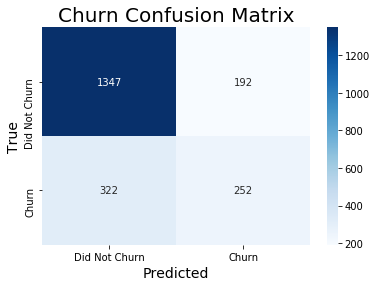

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      1539
           1       0.57      0.44      0.50       574

   micro avg       0.76      0.76      0.76      2113
   macro avg       0.69      0.66      0.67      2113
weighted avg       0.74      0.76      0.75      2113



In [10]:
# Predict on a random forest classification model using non-preprocessed training data

from sklearn.ensemble import RandomForestClassifier

# Create a trained random forest to predict whether or not a user will churn
trained_forest = RandomForestClassifier(n_estimators=1000).fit(cat_X_train, y_train)
y_pred = trained_forest.predict(cat_X_test)

_ = plot_results(y_test, y_pred)

The model trained on all the categorical columns of the dataset was able to achieve an F1-score of 0.84 and 0.51 on customers that didn't churn and churned, respectively. Without feature selection, the model's ability to flag users at risk of churning doesn't work much better than simple guessing. To see if there's any improvement with selecting features from the dataset, we'll first take a look at the 10 most important features for random forest classification using the feature importances.

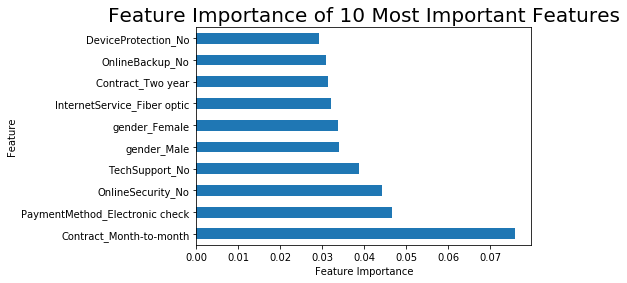

In [11]:
# Plot the feature importance value for the 10 most important features

feat_importances = pd.Series(trained_forest.feature_importances_, index=cat_X.columns)
_ = plt.title('Feature Importance of 10 Most Important Features', fontsize=20)
_ = plt.ylabel('Feature')
_ = plt.xlabel('Feature Importance')
_ = feat_importances.nlargest(10).plot(kind='barh')

Using the ```feature_importances_``` attribute, we can observe the 10 most important features for the dataset. Here, the best feature by a large margin in determining whether or not a customer churned was the customers month-to-month contract type. Other notable features are the fact that the user paid through electronic check, the fact that the user did not opt into online security and tech support, and the user's gender. Now that we have the ten most important features, let's now fit and predict another random forest classifier with these ten features.

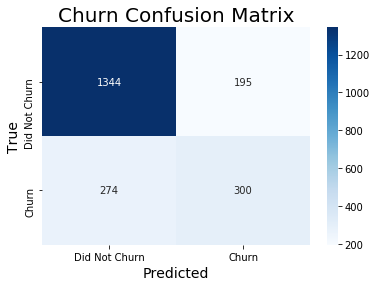

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1539
           1       0.61      0.52      0.56       574

   micro avg       0.78      0.78      0.78      2113
   macro avg       0.72      0.70      0.71      2113
weighted avg       0.77      0.78      0.77      2113



In [12]:
# Predict using the 10 most important categorical features

# Ignore the DataConversionWarning when converting int to floats
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Reduce the variable dataset to the 10 most important features
cat_X_red = cat_X[['MultipleLines_No','Contract_Two year', 'OnlineBackup_No',
               'InternetService_Fiber optic', 'gender_Female', 'gender_Male',
               'TechSupport_No', 'OnlineSecurity_No', 'PaymentMethod_Electronic check',
               'Contract_Month-to-month']]
cat_X_red_train, cat_X_red_test, y_train2, y_test2 = train_test_split(cat_X_red, y, 
                                                                       test_size = 0.30, 
                                                                       random_state = 42)

# Train a random forest on the reduced dataset and predict churn
rf = RandomForestClassifier(n_estimators=1000)
trained_forest2 = rf.fit(cat_X_red_train, y_train2)
y_pred2 = trained_forest2.predict(cat_X_red_test)

_ = plot_results(y_test2, y_pred2)

The random forest's F1 score for users at risk of churning improved by 5% by using the ten most important features. The F1 score for users that churned using these selected features a performed better on <b>less</b> feature information because the remaining 33 features didn't necessarily add useful information for the model to predict on. We can explore this topic further by modifying the number of features and evaluating the random forest classifier's performance on different numbers of selected features to find the optimal number of selected features for data prediction. 

In [13]:
# Find the optimal number of features between 10 and 40 features from the dataset
# Use 5 fold cross validation

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_validate
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

f1_high = 0
f1_list = []
for num_features in range(10, 45, 5):
    
    # Use the Random Forest Classifier to find the best features from given num_features
    model = RandomForestClassifier(random_state=42)
    model = model.fit(cat_X_train, y_train)
    model = SelectFromModel(model, prefit=True, 
                            max_features=num_features, threshold=-np.inf)
    selected_X = model.transform(cat_X_train)

    # Cross-validate the random forest on selected X array and return f1 score as results
    rf = RandomForestClassifier(n_estimators=1000, random_state=42)
    cv_results = cross_validate(rf, selected_X, y_train, cv=5, scoring='f1')
    f1 = np.mean(cv_results['test_score'])
    f1_list.append(f1)
    
    # Determine the optimal number of features
    if f1 > f1_high:
        best_model = model
        optimal_feature_num = num_features
        f1_high = f1

# Print the optimal number of features and the F1 scores for all tested number of features
print(f'Optimal Number of Features: {optimal_feature_num}')
for num_features, f1 in zip(range(10, 45, 5), f1_list):
    print(f'Churned F1-score for {num_features} Selected Features: {f1:.4f}')

Optimal Number of Features: 10
Churned F1-score for 10 Selected Features: 0.5265
Churned F1-score for 15 Selected Features: 0.4891
Churned F1-score for 20 Selected Features: 0.4897
Churned F1-score for 25 Selected Features: 0.4696
Churned F1-score for 30 Selected Features: 0.4672
Churned F1-score for 35 Selected Features: 0.4765
Churned F1-score for 40 Selected Features: 0.4809


After performing cross validation on random forest models for 10 to 40 selected features in increments of 5 features, the model with 10 selected features performed best after 5 fold CV. As such, we are going to build our model using these 10 categorical features.

In [14]:
cat_X_all_feat = cat_X
support = best_model.get_support()
column_list = list(cat_X_train.columns[support])
cat_X = cat_X[column_list]

## Numerical Data

In [15]:
# Retrieve the numerical data columns

num_types = ['int16','int32','int64','float16','float32','float64']
numerical_vars = list(data.select_dtypes(include=num_types).columns)
num_X = data[numerical_vars]

num_X = num_X.drop('SeniorCitizen', axis=1)
num_X.shape

(7043, 3)

In [16]:
num_X.head()

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65


After doing a little bit of data cleaning (senior citizens was encoded as 0/1 instead of categorical labels) we find that there are three numerical data columns. These columns are the number of months the user is tenured, the monthly amount that person was charged, and the total amount that that person was charged leading up to this point of analysis. What we're interested in seeing is if the numerical data is normally distributed for any of these columns. Normal distribution implies that we can standardize the data which may improve model performance. In addition, normal data will allow us to use linear regression techniques that can't be used if the data isn't normal.

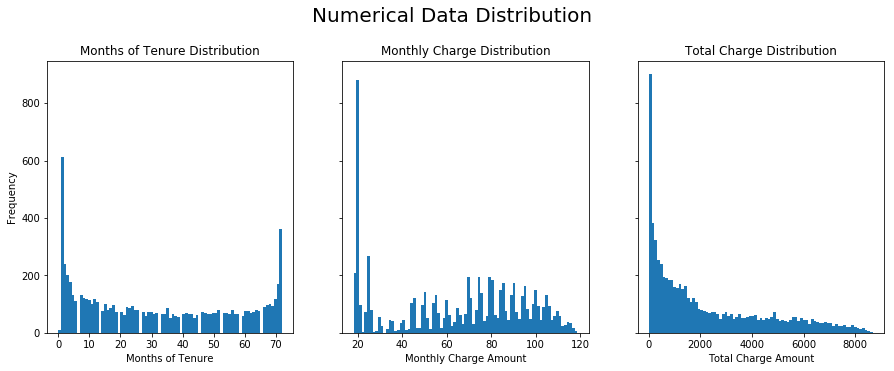

In [17]:
# Plot the numerical data

bins = int(np.sqrt(len(num_X.tenure)))
fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)

_ = axs[0].hist(num_X.tenure, bins=bins)
_ = axs[0].set_title('Months of Tenure Distribution')
_ = axs[0].set_xlabel('Months of Tenure')

_ = axs[1].hist(num_X.MonthlyCharges, bins=bins)
_ = axs[1].set_title('Monthly Charge Distribution')
_ = axs[1].set_xlabel('Monthly Charge Amount')

_ = axs[2].hist(num_X.TotalCharges, bins=bins)
_ = axs[2].set_title('Total Charge Distribution')
_ = axs[2].set_xlabel('Total Charge Amount')

_ = axs[0].set_ylabel('Frequency')
_ = fig.suptitle('Numerical Data Distribution', y=1.03, fontsize=20)

plt.show()

Plotting the number of users against the numerical columns shows that none of these columns were normally distributed. The bimodal distribution for the months of tenure suggests that no possible transformation could make such a distribution normal. However, the monthly and total amounts charged to the user may be transformed into a normal distribution if we attempt a power reduction technique.

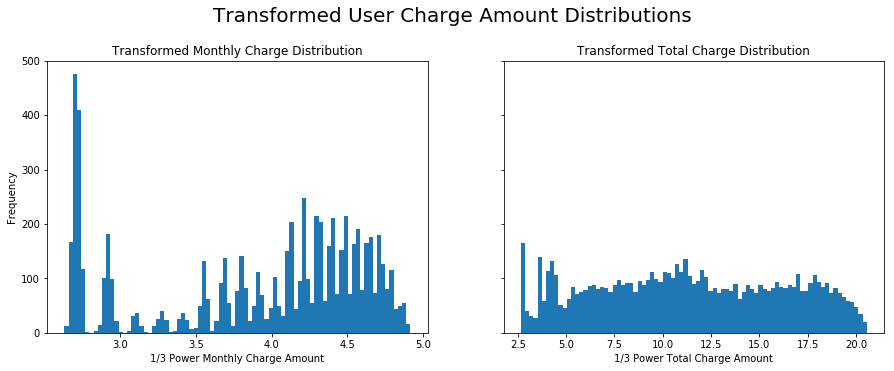

In [18]:
# Plot transformed numerical data

bins = int(np.sqrt(len(num_X.tenure)))
fig, axs = plt.subplots(1, 2, figsize=(15,5), sharey=True)

_ = axs[0].hist(num_X.MonthlyCharges**(1/3), bins=bins)
_ = axs[0].set_title('Transformed Monthly Charge Distribution')
_ = axs[0].set_xlabel('1/3 Power Monthly Charge Amount')

_ = axs[1].hist(num_X.TotalCharges**(1/3), bins=bins)
_ = axs[1].set_title('Transformed Total Charge Distribution')
_ = axs[1].set_xlabel('1/3 Power Total Charge Amount')

_ = axs[0].set_ylabel('Frequency')
_ = fig.suptitle('Transformed User Charge Amount Distributions', y=1.03, fontsize=20)

plt.show()

Using power reduction techniques didn't help with the non-normal data. The data is too sharply skewed right. Since the numerical data isn't normal, we'll have to use a model that's not sensitive to data normality like a random forest or neural network.

---

## Save DataFrame to File

In [19]:
# Create a DataFrame including all the categorical features

cat_X_all_feat['customerID'] = data['customerID']
num_X['customerID'] = data['customerID']

df_all_feat = cat_X_all_feat.merge(num_X, on='customerID')
df_all_feat['churn'] = y
df_all_feat.shape

(7043, 48)

In [20]:
# Create a DataFrame with the selected categorical features
cat_X['customerID'] = data['customerID']

df = cat_X.merge(num_X, on='customerID')
df['churn'] = y
df.shape

/Users/aldenchico/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(7043, 15)

In [21]:
df_all_feat.to_csv('output/2-EDA/all_features_telco.csv')
df.to_csv('output/2-EDA/clean_telco.csv')

Now that we're done analyzing and cleaning the Telco customer data, we can create two separate CSV files for the non-feature selected and feature selected datasets. We'll use these datasets to build predictive models that can flag whether or not a customer will churn. For the next article, we'll build compare different classifiers and determine which model is the most appropriate for Telco to release for distribution.